In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from siphon.catalog import TDSCatalog
import metpy.calc as mpcalc
from metpy.units import units
from scipy.ndimage import gaussian_filter
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from wrf import vinterp, to_np, getvar, CoordPair, vertcross, get_cartopy, latlon_coords


c:\Users\tonyi\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
# Define the URLs for the datasets of the variables we want to download (temperature, geopotential height, humidity, v-wind, u-wind)
urls = {
    'temperature_pl': 'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_130_t.ll025sc.2019022400_2019022423.nc',
    'geopotential_pl': 'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_129_z.ll025sc.2019022400_2019022423.nc',
    'mslp_sfc': 'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.128_151_msl.ll025sc.2019020100_2019022823.nc',    
    'humidity_pl': 'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_133_q.ll025sc.2019022400_2019022423.nc',
    'v_wind_pl': 'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_132_v.ll025uv.2019022400_2019022423.nc',
    'u_wind_pl': 'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_131_u.ll025uv.2019022400_2019022423.nc',
    'pv': 'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_060_pv.ll025sc.2019022400_2019022423.nc',
    'u_wind_sfc': 'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.228_131_u10n.ll025sc.2019020100_2019022823.nc',
    'v_wind_sfc': 'https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.sfc/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.sfc/201902/e5.oper.an.sfc.228_132_v10n.ll025sc.2019020100_2019022823.nc'
}

# Load the datasets from the URLs
datasets = {}
for var, url in urls.items():
    tds_catalog = TDSCatalog(url)
    ds_url = tds_catalog.datasets[0].access_urls['OPENDAP']
    ds = xr.open_dataset(ds_url).metpy.parse_cf()
    datasets[var] = ds

# Merge all pressure level datasets into a single Xarray Dataset
ds_pl = xr.merge([datasets['temperature_pl'], datasets['geopotential_pl'], datasets['humidity_pl'], datasets['v_wind_pl'], datasets['u_wind_pl'], datasets['pv']])

# Merge all surface datasets into a single Xarray Dataset
ds_sfc = xr.merge([datasets['mslp_sfc'], datasets['v_wind_sfc'], datasets['u_wind_sfc']])

c:\Users\tonyi\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_130_t.ll025sc.2019022400_2019022423.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_130_t.ll025sc.2019022400_2019022423.nc
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,
c:\Users\tonyi\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.html?dataset=files/g/d633000/e5.oper.an.pl/201902/e5.oper.an.pl.128_129_z.ll025sc.2019022400_2019022423.nc returned HTML. Changing to: https://thredds.rda.ucar.edu/thredds/catalog/files/g/d633000/e5.oper.an.pl/201902/catalog.xml?dataset=files

In [21]:
def theta_pv_cross_section(start_point, end_point, ds_pl, ds_sfc, directions, g):
    # Loop over the reanalysis time steps
    for i in range(0, len(ds_pl.time.values)):
        ds_pl_sliced = ds_pl.isel(time=i)
        ds_sfc_sliced = ds_sfc.isel(time=i)

        # Slice the dataset to get the data for the region of interest
        ds_pl_sliced = ds_pl_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))
        ds_sfc_sliced = ds_sfc_sliced.sel(latitude=slice(directions['North'], directions['South']), longitude=slice(directions['West'], directions['East']))

        # Slice the dataset to get the data for the pressure level at 250 hPa
        u_sliced = ds_pl_sliced['U'].sel(level=slice(500, 1000)) # units: m/s
        v_sliced = ds_pl_sliced['V'].sel(level=slice(500, 1000)) # units: m/s
        q_sliced = ds_pl_sliced['Q'].sel(level=slice(500, 1000)) # units: kg/kg
        u_500 = ds_pl_sliced['U'].sel(level=500) # units: m/s
        v_500 = ds_pl_sliced['V'].sel(level=500) # units: m/s
        z_500 = ds_pl_sliced['Z'].sel(level=500) / g # units: m
        pressure_levels = u_500.level * 100 # units: Pa

        pressure_levels_ivt = u_sliced.level[::-1] * 100 # units: Pa

        # Get the lats and lons
        lats = u_sliced['latitude'][:]
        lons = u_sliced['longitude'][:] 

        # Calculate the integrated vapor transport (IVT) using the u- and v-wind components and the specific humidity
        u_ivt = -1 / g * np.trapz(u_sliced * q_sliced, pressure_levels_ivt, axis=0)
        v_ivt = -1 / g * np.trapz(v_sliced * q_sliced, pressure_levels_ivt, axis=0)

        # Calculate the IVT magnitude
        ivt = np.sqrt(u_ivt**2 + v_ivt**2)

        # Create an xarray DataArray for the IVT
        ivt_da = xr.DataArray(ivt, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']})

        # Define the color levels and colors for the IVT plot
        ivt_levels = [250, 300, 400, 500, 600, 700, 800, 1000, 1200, 1400, 1600, 1800]
        ivt_colors = ['#ffff00', '#ffe400', '#ffc800', '#ffad00', '#ff8200', '#ff5000', '#ff1e00', '#eb0010', '#b8003a', '#850063', '#570088']
        ivt_cmap = mcolors.ListedColormap(ivt_colors)
        ivt_norm = mcolors.BoundaryNorm(ivt_levels, ivt_cmap.N)

        # Mask the IVT values below 250 kg/m/s and create a filtered DataArray for the u- and v-wind components
        mask = ivt_da >= 250
        u_ivt_filtered = xr.DataArray(u_ivt, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']}).where(mask, drop=True)
        v_ivt_filtered = xr.DataArray(v_ivt, dims=['latitude', 'longitude'], coords={'latitude': u_sliced['latitude'], 'longitude': u_sliced['longitude']}).where(mask, drop=True)

        # Slice the dataset to get the mslp
        mslp = ds_sfc_sliced['MSL'] / 100 # units: hPa

        # Calculate the wind speed at 250 hPa
        wind_speed_500 = mpcalc.wind_speed(u_500, v_500)

        # Get the time of the current time step and create a pandas DatetimeIndex
        time = ds_pl_sliced.time.values
        int_datetime_index = pd.DatetimeIndex([time])

        lat_values = np.linspace(start_point[0], end_point[0])
        lon_values = np.linspace(start_point[1], end_point[1])
        x = xr.DataArray(lon_values, dims='Lat_Lon')
        y = xr.DataArray(lat_values, dims='Lat_Lon')
        ds_cross = ds_pl_sliced.interp(longitude=x, latitude=y, method='nearest')
        t = ds_cross['T'].sel(level=slice(150, 1000)) # units: K
        pressure_levels = t['level'] # units: hPa
        theta = mpcalc.potential_temperature(pressure_levels, t) # units: K
        pv_crossed = ds_cross['PV'].sel(level=slice(150, 1000)) # units: K

        # Define the color levels and colors for the potential vorticity
        levels = np.arange(0, 3.26, 0.25)
        colors = ['white', '#d1e9f7', '#a5cdec', '#79a3d5', '#69999b', '#78af58', '#b0cc58', '#f0d95f', '#de903e', '#cb5428', '#b6282a', '#9b1622', '#7a1419']
        cmap = mcolors.ListedColormap(colors)
        norm = mcolors.BoundaryNorm(levels, cmap.N)

        # Smooth the PV and potential temperature 
        pv_smoothed = gaussian_filter(pv_crossed, sigma=1)
        theta_smoothed = gaussian_filter(theta, sigma=1)

        # Create the figure 
        fig, ax = plt.subplots(figsize=(10, 6))

        # Plot the isentropes and potential vorticity 
        isentropes = ax.contour(ds_cross['longitude'], pressure_levels, theta_smoothed, colors='black', levels=np.arange(250, 450, 1))
        ax.clabel(isentropes, inline=True, inline_spacing=5, fontsize=10, fmt='%i')
        pv_cf = ax.contourf(ds_cross['longitude'], pressure_levels, pv_smoothed * 1e6, cmap=cmap, levels=levels, norm=norm, extend='max')
        plt.colorbar(pv_cf, orientation='vertical', label='PV (m$^2$ s$^{-1}$ K kg$^{-1}$)', fraction=0.046, pad=0.04)


        # Adding the isentropes to the legend with a custom label
        theta_line = plt.Line2D([0], [0], color='black', linewidth=1, label=r'$\theta$ Potential Temperature (K)')

        # Creating the legend with the custom entries
        ax.legend(handles=[theta_line], loc='upper right')
        ax.set_yticks(pressure_levels)
        ax.set_yticklabels(list(pressure_levels.values))
        plt.ylim(1000, 600)
        plt.xlabel('Longitude')
        plt.ylabel('Pressure (hPa)')
        plt.title('ERA5 Reanalysis Vertical Cross-Section of Potential Vorticity and Potential Temperature')

        # Manually set y-axis tick marks
        custom_ticks = [1000, 900, 800, 700, 600]  
        ax.set_yticks(custom_ticks)
        ax.set_yticklabels([str(tick) for tick in custom_ticks])

        # Add labels "A" and "A'" to the bottom left and right
        ax.text(0, -0.1, 'A', transform=ax.transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='left', fontweight='bold')
        ax.text(1, -0.1, "A'", transform=ax.transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right', fontweight='bold')

        # Add an inset of the plan view to provide additional context 
        ax_inset = fig.add_axes([0.10, 0.63, 0.25, 0.25], projection=ccrs.PlateCarree())
        ax_inset.set_extent([directions['East'], directions['West'], directions['South'], directions['North']])
        ax_inset.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
        ax_inset.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray', linewidth=0.5)
        ax_inset.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
        ax_inset.add_feature(cfeature.OCEAN, color='white')
        ax_inset.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax_inset.add_feature(cfeature.LAND, color='#fbf5e9')
        ax_inset.plot([start_point[1], end_point[1]], [start_point[0], end_point[0]],
                            color="black", marker="o", transform=ccrs.PlateCarree())
        # Add text annotations
        ax_inset.text(start_point[1], start_point[0], "A", transform=ccrs.PlateCarree(),
                    verticalalignment='bottom', horizontalalignment='right', fontweight='bold', fontsize=12)
        ax_inset.text(end_point[1], end_point[0], "A'", transform=ccrs.PlateCarree(),
                    verticalalignment='bottom', horizontalalignment='right', fontweight='bold', fontsize=12)

        #isohypses = ax_inset.contour(z_500['longitude'], z_500['latitude'], z_500, colors='black', levels=np.arange(5000, 6000, 50), linewidths=1)

    
        c = ax_inset.contour(ivt_da['longitude'], ivt_da['latitude'], gaussian_filter(ivt_da, sigma=1), colors='black', levels=ivt_levels, linewidths=0.5)
        cf = ax_inset.contourf(ivt_da['longitude'], ivt_da['latitude'], gaussian_filter(ivt_da, sigma=1), cmap=ivt_cmap, levels=ivt_levels, norm=ivt_norm, extend='max')

        # Plot the IVT vectors
        step = 5 
        plt.quiver(u_ivt_filtered['longitude'][::step], u_ivt_filtered['latitude'][::step], u_ivt_filtered[::step, ::step], v_ivt_filtered[::step, ::step], scale=500,scale_units='xy', color='black')

        #plt.tight_layout()
        plt.show()

c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. 

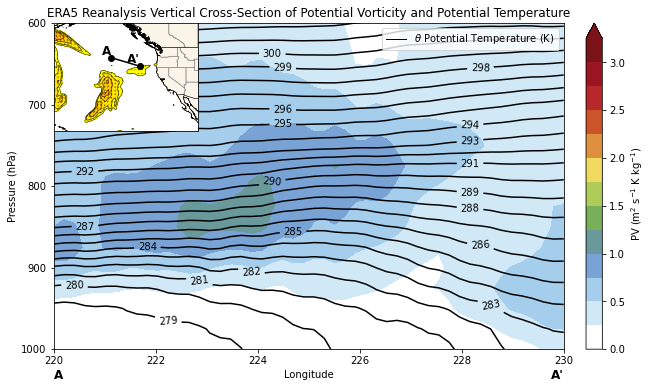

c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. 

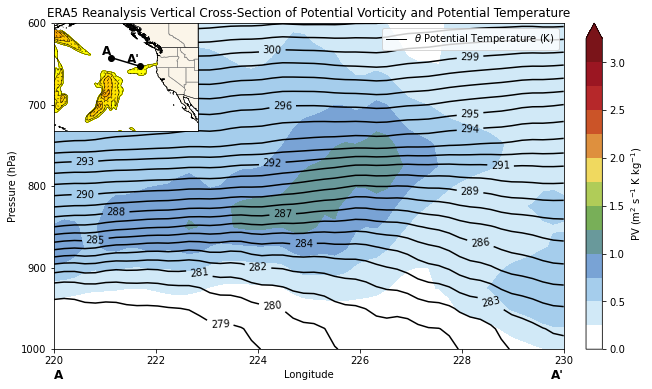

c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. 

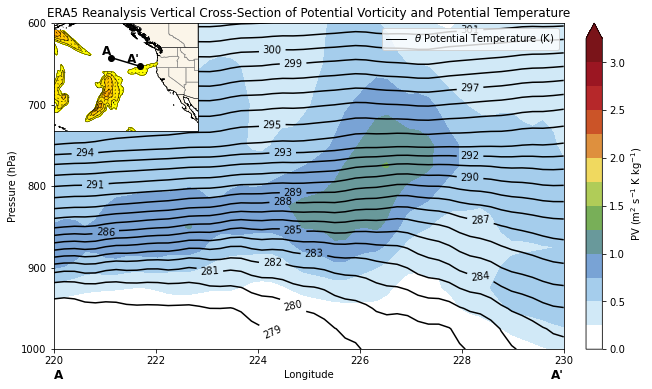

c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. 

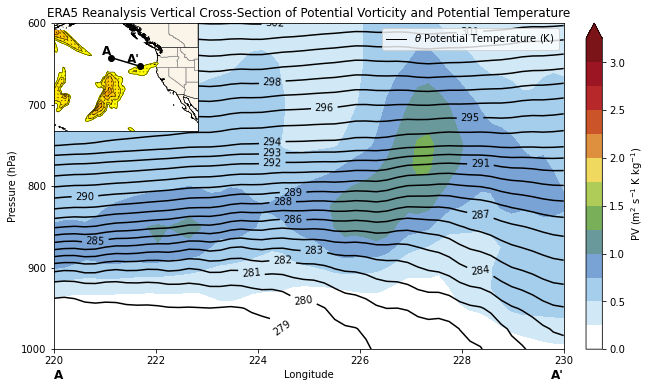

c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. 

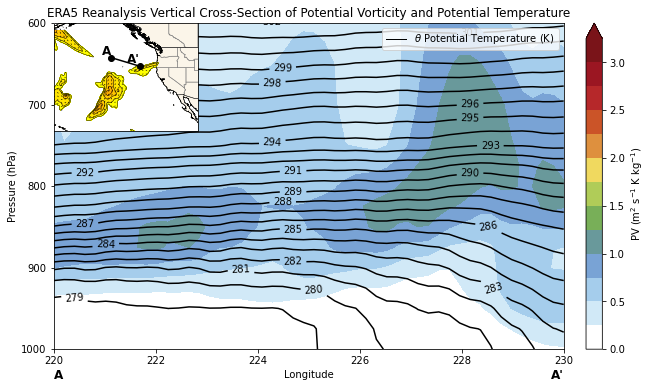

c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. 

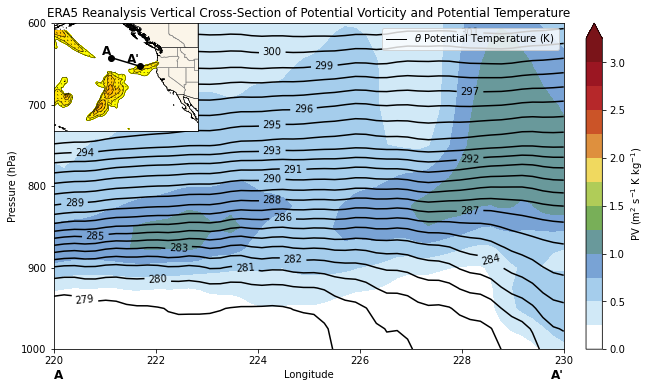

c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. 

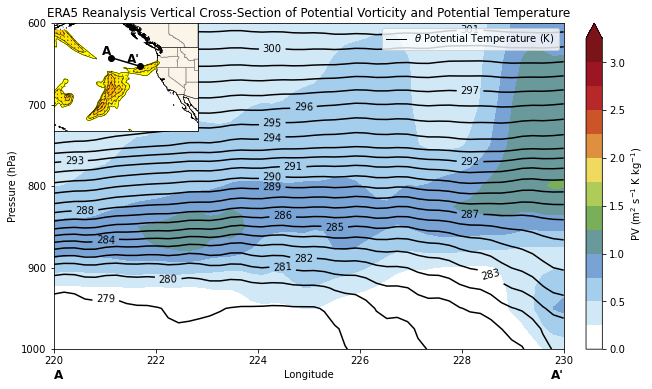

c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. 

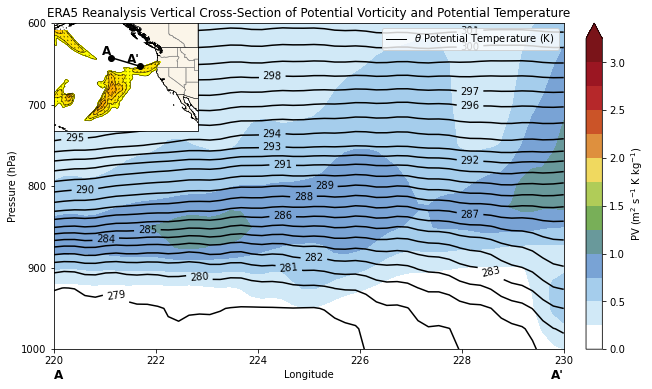

c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. 

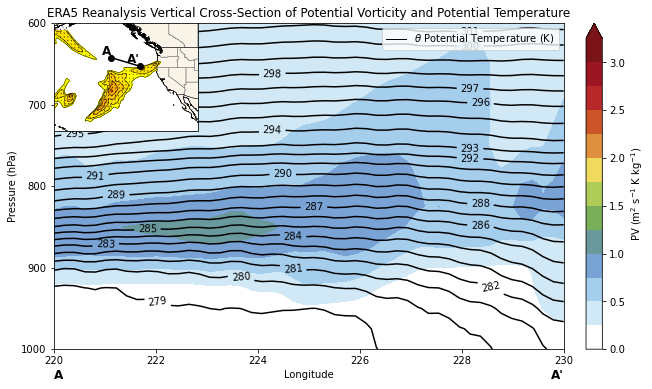

c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. 

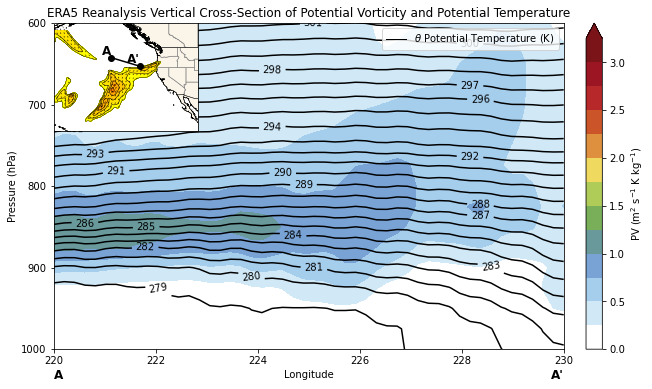

c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. 

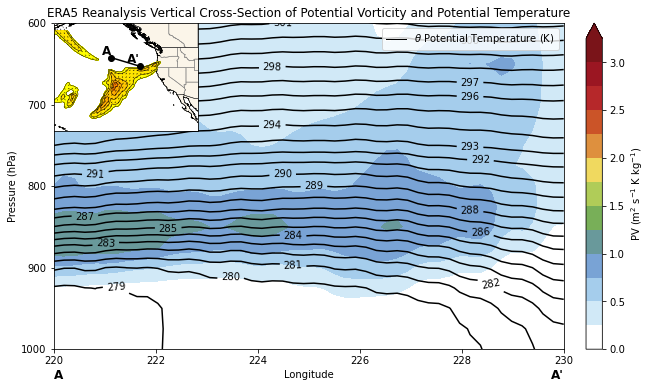

c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. 

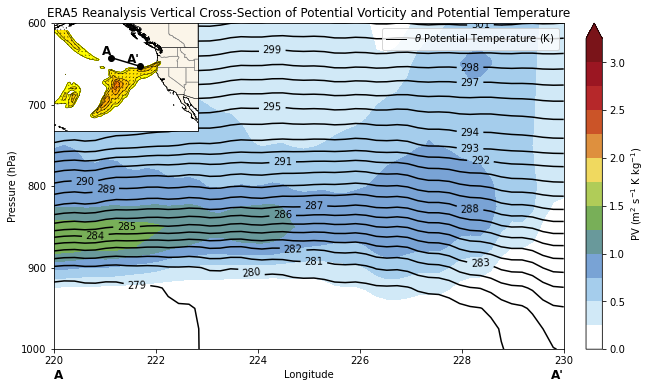

c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. 

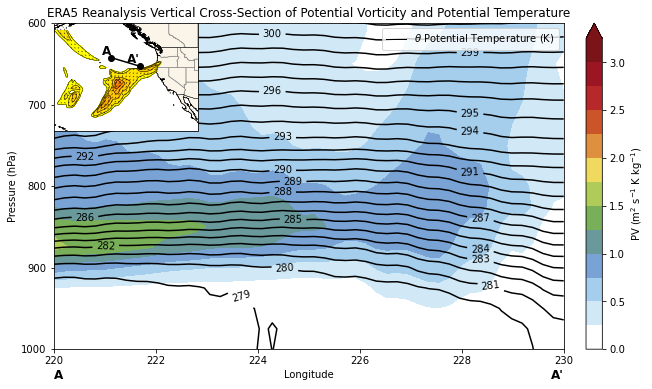

c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. 

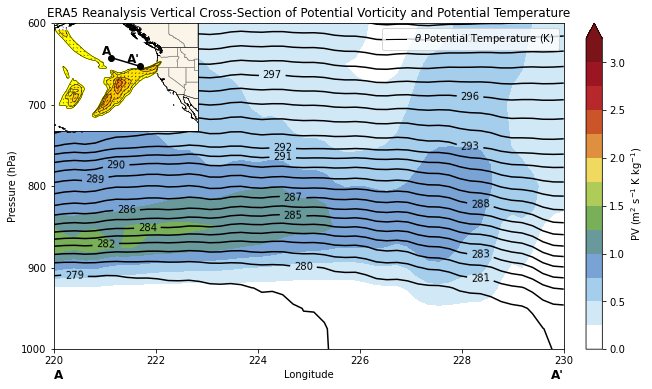

c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. 

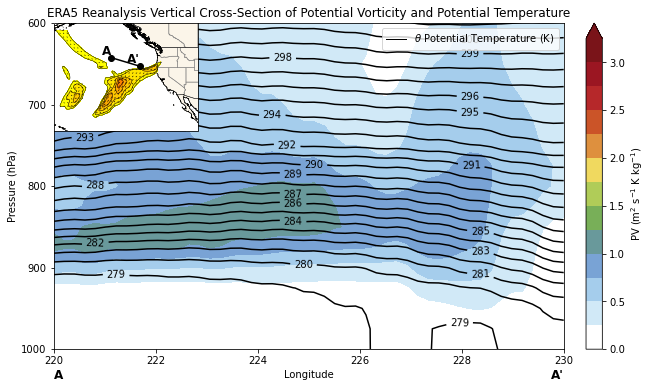

c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. 

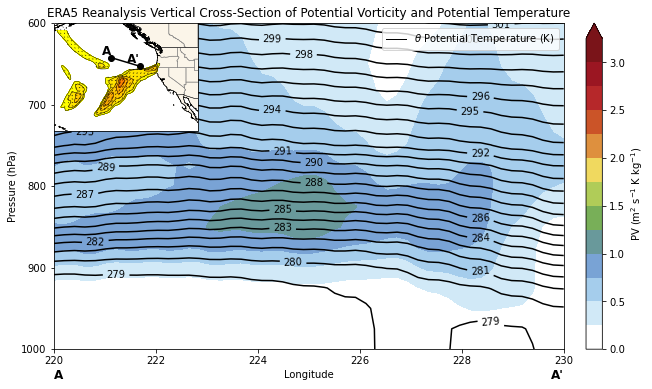

c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. 

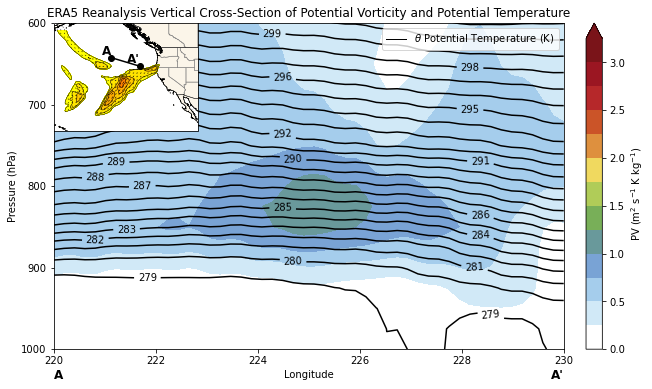

c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. 

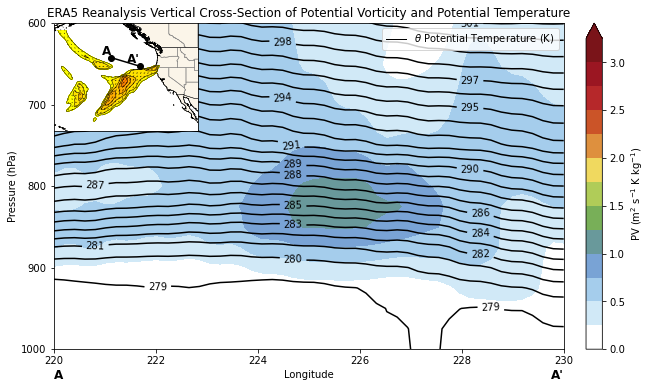

c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. 

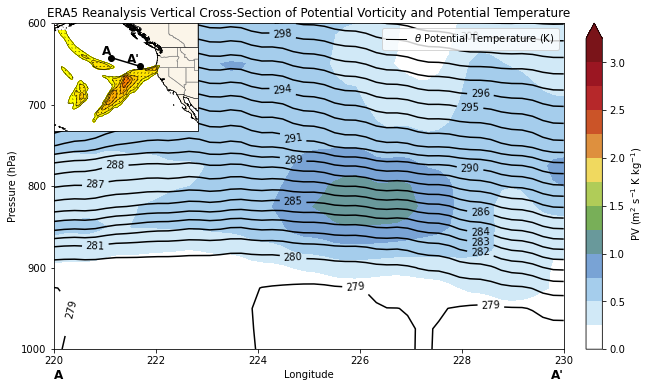

c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. 

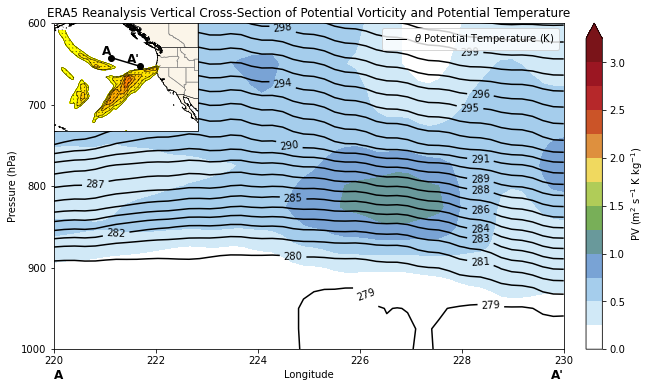

c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. 

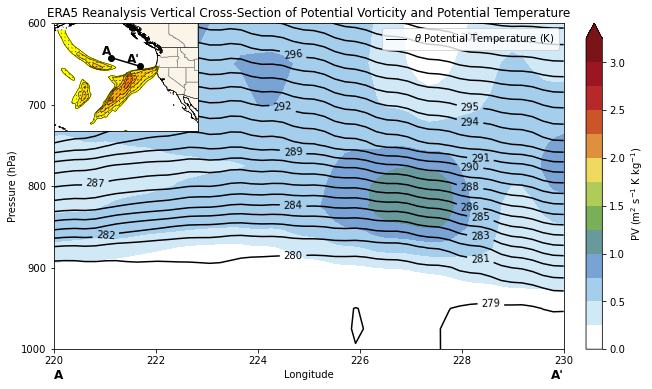

c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. 

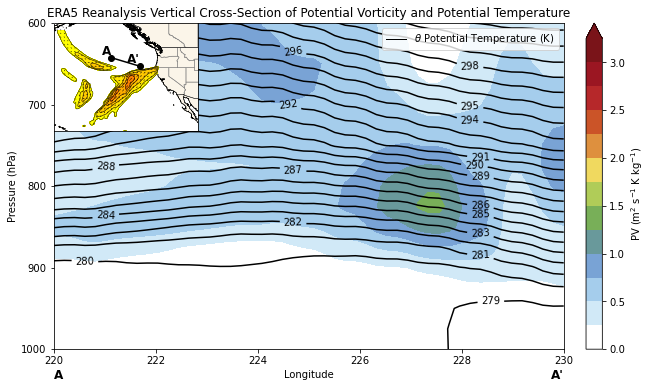

c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. 

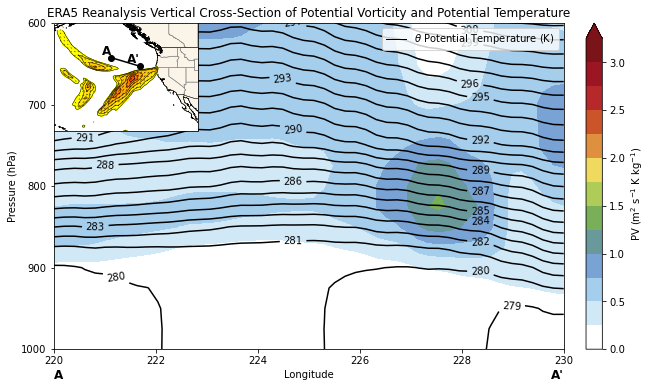

c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
c:\Users\tonyi\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. 

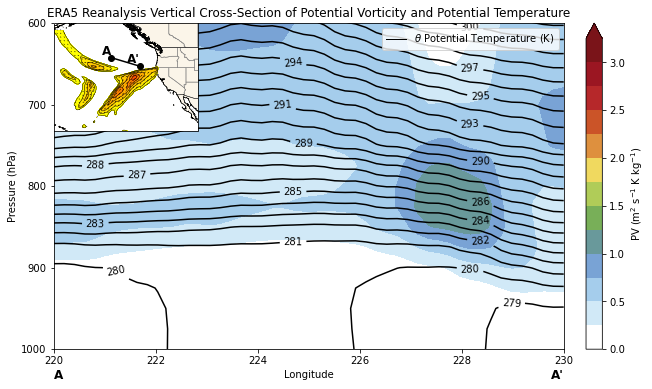

In [22]:
if __name__ == '__main__':
    directions = {'North': 55, 
                  'East': 250, 
                  'South': 20, 
                  'West': 200} #units: degrees North, degrees East
    start_point = (45.5, 360-140) #units: degrees North, degrees East
    end_point = (42.5, 360-130) #units: degrees North, degrees East
    g = 9.81 # units: m/s^2
    theta_pv_cross_section(start_point, end_point, ds_pl, ds_sfc, directions, g)